### Import necessary Libray

In [ ]:
import numpy as np
import pandas as pd
import spacy
import pickle
from matplotlib import pyplot as plt
from scipy import spatial

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Load dataframe

In [2]:
df = pd.read_csv("./output/queries_df.csv")
df.head()

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
1,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
2,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
3,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
4,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.shape

(189799, 7)

In [4]:
categories = ["REMEMBERING", "UNDERSTANDING", "APPLYING", "ANALYZING", "EVALUATING", "CREATING"]

### Proportion of any bloom class

In [5]:
df[categories].sum()

REMEMBERING      45873.0
UNDERSTANDING     8520.0
APPLYING         23453.0
ANALYZING        39990.0
EVALUATING       16677.0
CREATING         55286.0
dtype: float64

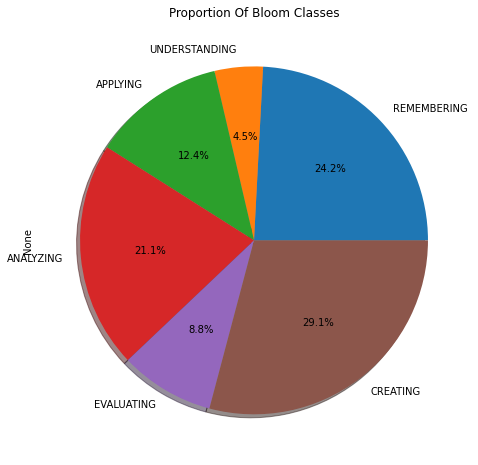

In [6]:
df[categories].sum().plot.pie(figsize=(8, 8), title="Proportion Of Bloom Classes", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)

### Prepocessing text

In [7]:
df.columns

Index(['QUERY', 'REMEMBERING', 'UNDERSTANDING', 'APPLYING', 'ANALYZING',
       'EVALUATING', 'CREATING'],
      dtype='object')

#### Split into train - valid - test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df["QUERY"], df[categories], test_size=0.25, random_state=41)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=41)

In [10]:
proportion_data = pd.DataFrame([X_train.shape[0], X_valid.shape[0], X_test.shape[0]], columns=["Counts"], index=["Train", "Valid", "Test"])
proportion_data

,Counts
Train,120996
Valid,21353
Test,47450


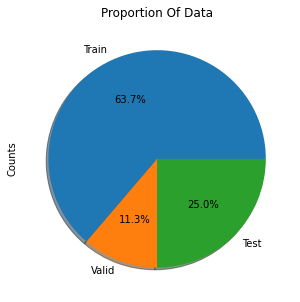

In [12]:
proportion_data.Counts.plot.pie(figsize=(5, 5), title="Proportion Of Data", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)

In [13]:
X_train.head()

71543     what is the difference between the slope of ta...
155386    how many casualties were there when america bo...
75048     could we also find the entire area under the c...
130361                          where did theia come from ?
171257            how does the nuclear membrane disappear ?
Name: QUERY, dtype: object

Preprocessing Datas

In [14]:
from helper import *
from models import *

In [15]:
def join_process(text):
    return " ".join(process_text(text))

In [16]:
X_valid_transform = X_valid.apply(join_process)

In [17]:
X_valid_transform.head()

133312    book say coeffici static friction equal forc f...
137719                               345 pi mean 345 x 3.14
16430     forc appli constantli static friction affect o...
109978                              exactli adjac angl mean
48047                              what 360 degre angl call
Name: QUERY, dtype: object

In [18]:
X_train_transform = X_train.apply(join_process)

In [19]:
X_test_transform = X_test.apply(join_process)

In [20]:
X_train_transform.sample(5)

143422    9:45 atom consid wave like ration around nucle...
113296                              distinguish ion element
143101    want know mani neutron carbon 14 would subract...
130425                            9:00 rock earth go molten
164040    happen two hydrogen atom sulfur becom oxid bui...
Name: QUERY, dtype: object

### Building Machine Learning Pipeline

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

In [34]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('ovo', OneVsRestClassifier(LogisticRegression(random_state=40, class_weight="balanced", solver="lbfgs", multi_class="auto", max_iter=7500))),
])

In [23]:
y_train.head()

,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
71543,0.0,0.0,0.0,1.0,0.0,0.0
155386,1.0,0.0,0.0,0.0,0.0,0.0
75048,0.0,0.0,1.0,0.0,0.0,0.0
130361,0.0,0.0,0.0,1.0,0.0,0.0
171257,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
X_train_transform.values[0]

'differ slope tangent line slope secant line'

In [35]:
pipe = pipe.fit(X_train_transform.values, y_train.values)

In [36]:
valid_pred = pipe.predict(X_valid_transform.values)

In [37]:
valid_pred[:5]

array([[1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [38]:
y_valid.values[:5]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [39]:
valid_pred_prob = pipe.predict_proba(X_valid_transform.values)

In [40]:
valid_pred_prob[:5]

array([[0.55305266, 0.00130593, 0.01320681, 0.53511798, 0.04416496,
        0.82237864],
       [0.71877859, 0.2378848 , 0.06077802, 0.90506606, 0.06308836,
        0.14950392],
       [0.66938446, 0.01146767, 0.59534022, 0.65448266, 0.01681093,
        0.18379665],
       [0.6058852 , 0.83209425, 0.04916805, 0.6875266 , 0.0541345 ,
        0.37155075],
       [0.49900224, 0.16299699, 0.36717646, 0.30320506, 0.39105987,
        0.4197216 ]])

In [41]:
from sklearn.metrics import roc_curve, auc

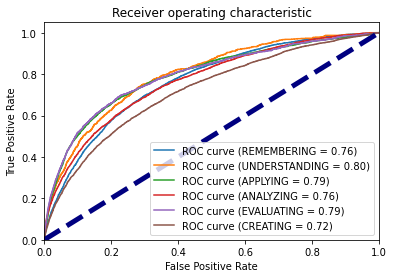

In [47]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(categories)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid.values[:, i], valid_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.values.ravel(), valid_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
for i in range(n_classes):
    lw = i
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({categories[i]} = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
import metrics

In [50]:
performances = metrics.get_performance_metrics(y_valid.values, valid_pred_prob, categories)

In [51]:
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,3551,11385,4859,1558,0.699,0.239,0.695,0.701,0.422,0.88,0.764,0.525,0.5
UNDERSTANDING,564,16726,3692,371,0.81,0.044,0.603,0.819,0.133,0.978,0.796,0.217,0.5
APPLYING,1693,15125,3608,927,0.788,0.123,0.646,0.807,0.319,0.942,0.792,0.427,0.5
ANALYZING,2990,12363,4418,1582,0.719,0.214,0.654,0.737,0.404,0.887,0.765,0.499,0.5
EVALUATING,1197,15894,3596,666,0.8,0.087,0.643,0.815,0.25,0.96,0.794,0.36,0.5
CREATING,3704,11054,4045,2550,0.691,0.293,0.592,0.732,0.478,0.813,0.719,0.529,0.5


In [52]:
statistics = metrics.bootstrap_auc(y_valid.values, valid_pred_prob, categories)

In [54]:
metrics.print_confidence_intervals(categories, statistics)

,Mean AUC (CI 5%-95%)
REMEMBERING,0.76 (0.73-0.79)
UNDERSTANDING,0.80 (0.75-0.85)
APPLYING,0.79 (0.75-0.82)
ANALYZING,0.76 (0.73-0.80)
EVALUATING,0.80 (0.76-0.83)
CREATING,0.72 (0.69-0.74)


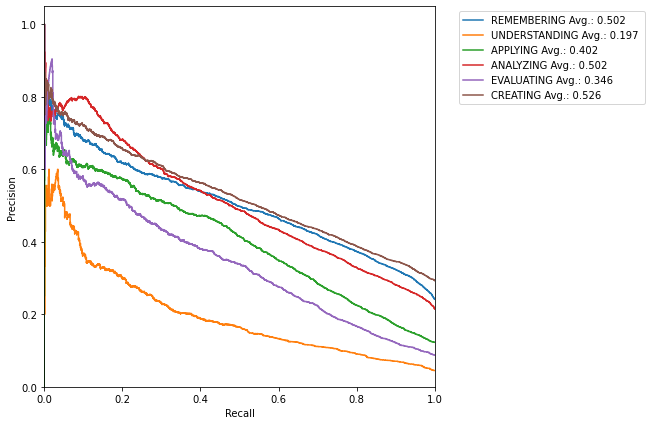

In [55]:
metrics.get_curve(y_valid.values, valid_pred_prob, categories, curve='prc')

In [61]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

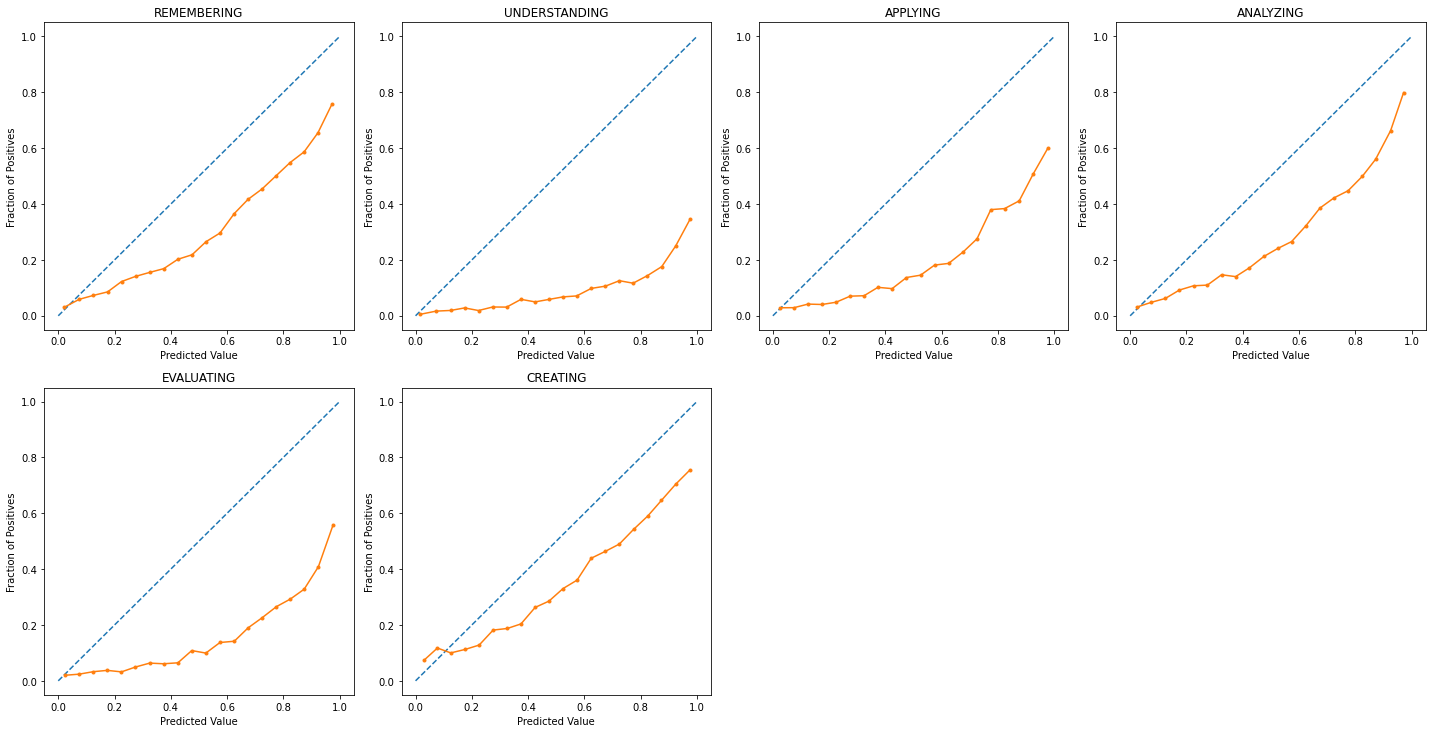

In [62]:
plot_calibration_curve(y_valid.values, valid_pred_prob, categories)

In [65]:
# min_df=5, max_df=0.2, stop_words="english"
pipe_chains = [Pipeline([
    ('cv', CountVectorizer()),
    (f'chain_{i}', ClassifierChain(LogisticRegression(random_state=40, class_weight="balanced", solver="liblinear", multi_class="ovr", max_iter=7500)
                             , order='random', random_state=i)) ,
]) for i in range(10)]

In [66]:
import datetime
print(f"Start {datetime.datetime.now()}")
for i, chain in enumerate(pipe_chains):
    current_time = datetime.datetime.now()
    chain.fit(X_train_transform.values, y_train.values)
    print(f"End Chain {i} after {datetime.datetime.now() - current_time}")

Start 2020-10-25 19:12:17.257217
End Chain 0 after 0:00:15.671255
End Chain 1 after 0:00:16.313963
End Chain 2 after 0:00:17.844819
End Chain 3 after 0:00:15.219960
End Chain 4 after 0:00:18.445594
End Chain 5 after 0:00:15.923945
End Chain 6 after 0:00:18.713667
End Chain 7 after 0:00:15.408791
End Chain 8 after 0:00:15.911243
End Chain 9 after 0:00:16.292634


In [67]:
valid_pred_prob_chains = np.array([
    chain.predict_proba(X_valid_transform) for chain in pipe_chains
])

In [68]:
from IPython.display import display

for valid_pred_prob_chain in valid_pred_prob_chains:
    display(metrics.get_performance_metrics(y_valid.values, valid_pred_prob_chain, categories))

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15465,779,4134,0.77,0.239,0.191,0.952,0.556,0.789,0.705,0.284,0.5
UNDERSTANDING,409,17865,2553,526,0.856,0.044,0.437,0.875,0.138,0.971,0.737,0.21,0.5
APPLYING,1423,15746,2987,1197,0.804,0.123,0.543,0.841,0.323,0.929,0.714,0.405,0.5
ANALYZING,1842,14389,2392,2730,0.76,0.214,0.403,0.857,0.435,0.841,0.712,0.418,0.5
EVALUATING,146,19381,109,1717,0.914,0.087,0.078,0.994,0.573,0.919,0.723,0.138,0.5
CREATING,3704,11053,4046,2550,0.691,0.293,0.592,0.732,0.478,0.813,0.719,0.529,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,2327,13222,3022,2782,0.728,0.239,0.455,0.814,0.435,0.826,0.695,0.445,0.5
UNDERSTANDING,500,17201,3217,435,0.829,0.044,0.535,0.842,0.135,0.975,0.752,0.215,0.5
APPLYING,1693,15125,3608,927,0.788,0.123,0.646,0.807,0.319,0.942,0.792,0.427,0.5
ANALYZING,1276,15452,1329,3296,0.783,0.214,0.279,0.921,0.49,0.824,0.71,0.356,0.5
EVALUATING,754,17206,2284,1109,0.841,0.087,0.405,0.883,0.248,0.939,0.662,0.308,0.5
CREATING,913,14659,440,5341,0.729,0.293,0.146,0.971,0.675,0.733,0.634,0.24,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,845,15760,484,4264,0.778,0.239,0.165,0.97,0.636,0.787,0.652,0.263,0.5
UNDERSTANDING,473,17363,3055,462,0.835,0.044,0.506,0.85,0.134,0.974,0.725,0.212,0.5
APPLYING,1037,16689,2044,1583,0.83,0.123,0.396,0.891,0.337,0.913,0.706,0.364,0.5
ANALYZING,2190,13649,3132,2382,0.742,0.214,0.479,0.813,0.411,0.851,0.673,0.443,0.5
EVALUATING,1197,15893,3597,666,0.8,0.087,0.643,0.815,0.25,0.96,0.794,0.36,0.5
CREATING,1705,13488,1611,4549,0.712,0.293,0.273,0.893,0.514,0.748,0.652,0.356,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1140,15117,1127,3969,0.761,0.239,0.223,0.931,0.503,0.792,0.699,0.309,0.5
UNDERSTANDING,170,19338,1080,765,0.914,0.044,0.182,0.947,0.136,0.962,0.719,0.156,0.5
APPLYING,393,18520,213,2227,0.886,0.123,0.15,0.989,0.649,0.893,0.754,0.244,0.5
ANALYZING,2990,12363,4418,1582,0.719,0.214,0.654,0.737,0.404,0.887,0.765,0.499,0.5
EVALUATING,575,17750,1740,1288,0.858,0.087,0.309,0.911,0.248,0.932,0.678,0.275,0.5
CREATING,3522,11103,3996,2732,0.685,0.293,0.563,0.735,0.468,0.803,0.686,0.511,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1589,14515,1729,3520,0.754,0.239,0.311,0.894,0.479,0.805,0.694,0.377,0.5
UNDERSTANDING,57,20218,200,878,0.95,0.044,0.061,0.99,0.222,0.958,0.745,0.096,0.5
APPLYING,401,18526,207,2219,0.886,0.123,0.153,0.989,0.66,0.893,0.756,0.248,0.5
ANALYZING,2403,13149,3632,2169,0.728,0.214,0.526,0.784,0.398,0.858,0.701,0.453,0.5
EVALUATING,1197,15893,3597,666,0.8,0.087,0.643,0.815,0.25,0.96,0.794,0.36,0.5
CREATING,3032,11776,3323,3222,0.693,0.293,0.485,0.78,0.477,0.785,0.648,0.481,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1630,14460,1784,3479,0.754,0.239,0.319,0.89,0.477,0.806,0.699,0.382,0.5
UNDERSTANDING,322,18535,1883,613,0.883,0.044,0.344,0.908,0.146,0.968,0.73,0.205,0.5
APPLYING,1423,15746,2987,1197,0.804,0.123,0.543,0.841,0.323,0.929,0.714,0.405,0.5
ANALYZING,839,16432,349,3733,0.809,0.214,0.184,0.979,0.706,0.815,0.703,0.291,0.5
EVALUATING,601,17689,1801,1262,0.857,0.087,0.323,0.908,0.25,0.933,0.641,0.282,0.5
CREATING,3704,11053,4046,2550,0.691,0.293,0.592,0.732,0.478,0.813,0.719,0.529,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,2833,12350,3894,2276,0.711,0.239,0.555,0.76,0.421,0.844,0.705,0.479,0.5
UNDERSTANDING,53,20202,216,882,0.949,0.044,0.057,0.989,0.197,0.958,0.744,0.088,0.5
APPLYING,392,18505,228,2228,0.885,0.123,0.15,0.988,0.632,0.893,0.761,0.242,0.5
ANALYZING,1314,15496,1285,3258,0.787,0.214,0.287,0.923,0.506,0.826,0.704,0.366,0.5
EVALUATING,1197,15893,3597,666,0.8,0.087,0.643,0.815,0.25,0.96,0.794,0.36,0.5
CREATING,3032,11776,3323,3222,0.693,0.293,0.485,0.78,0.477,0.785,0.648,0.481,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1961,13872,2372,3148,0.741,0.239,0.384,0.854,0.453,0.815,0.693,0.415,0.5
UNDERSTANDING,64,20241,177,871,0.951,0.044,0.068,0.991,0.266,0.959,0.742,0.109,0.5
APPLYING,724,17836,897,1896,0.869,0.123,0.276,0.952,0.447,0.904,0.748,0.341,0.5
ANALYZING,2990,12363,4418,1582,0.719,0.214,0.654,0.737,0.404,0.887,0.765,0.499,0.5
EVALUATING,160,19398,92,1703,0.916,0.087,0.086,0.995,0.635,0.919,0.782,0.151,0.5
CREATING,3522,11103,3996,2732,0.685,0.293,0.563,0.735,0.468,0.803,0.686,0.511,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,3551,11385,4859,1558,0.699,0.239,0.695,0.701,0.422,0.88,0.764,0.525,0.5
UNDERSTANDING,187,19642,776,748,0.929,0.044,0.2,0.962,0.194,0.963,0.729,0.197,0.5
APPLYING,1474,15612,3121,1146,0.8,0.123,0.563,0.833,0.321,0.932,0.745,0.409,0.5
ANALYZING,793,16447,334,3779,0.807,0.214,0.173,0.98,0.704,0.813,0.707,0.278,0.5
EVALUATING,297,18923,567,1566,0.9,0.087,0.159,0.971,0.344,0.924,0.702,0.218,0.5
CREATING,2551,12235,2864,3703,0.692,0.293,0.408,0.81,0.471,0.768,0.655,0.437,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,973,15463,781,4136,0.77,0.239,0.19,0.952,0.555,0.789,0.702,0.284,0.5
UNDERSTANDING,491,17217,3201,444,0.829,0.044,0.525,0.843,0.133,0.975,0.743,0.212,0.5
APPLYING,1233,16292,2441,1387,0.821,0.123,0.471,0.87,0.336,0.922,0.698,0.392,0.5
ANALYZING,1849,14388,2393,2723,0.76,0.214,0.404,0.857,0.436,0.841,0.711,0.42,0.5
EVALUATING,142,19380,110,1721,0.914,0.087,0.076,0.994,0.563,0.918,0.716,0.134,0.5
CREATING,3704,11053,4046,2550,0.691,0.293,0.592,0.732,0.478,0.813,0.719,0.529,0.5


In [69]:
valid_pred_prob_ensemble = valid_pred_prob_chains.mean(axis=0)

In [70]:
metrics.get_performance_metrics(y_valid.values, valid_pred_prob_ensemble, categories)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.191,0.962,0.609,0.791,0.743,0.291,0.5
UNDERSTANDING,160,20081,337,775,0.948,0.044,0.171,0.983,0.322,0.963,0.787,0.223,0.5
APPLYING,687,18213,520,1933,0.885,0.123,0.262,0.972,0.569,0.904,0.781,0.359,0.5
ANALYZING,1096,16169,612,3476,0.809,0.214,0.24,0.964,0.642,0.823,0.747,0.349,0.5
EVALUATING,291,19188,302,1572,0.912,0.087,0.156,0.985,0.491,0.924,0.783,0.237,0.5
CREATING,2140,13559,1540,4114,0.735,0.293,0.342,0.898,0.582,0.767,0.715,0.431,0.5


In [71]:
thresholds_range = np.linspace(0.5, 0.85, 10)
thresholds_range

array([0.5       , 0.53888889, 0.57777778, 0.61666667, 0.65555556,
       0.69444444, 0.73333333, 0.77222222, 0.81111111, 0.85      ])

In [72]:
thresholds = np.array([
    [threshold] * len(categories) for threshold in thresholds_range
])
thresholds

array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       ],
       [0.53888889, 0.53888889, 0.53888889, 0.53888889, 0.53888889,
        0.53888889],
       [0.57777778, 0.57777778, 0.57777778, 0.57777778, 0.57777778,
        0.57777778],
       [0.61666667, 0.61666667, 0.61666667, 0.61666667, 0.61666667,
        0.61666667],
       [0.65555556, 0.65555556, 0.65555556, 0.65555556, 0.65555556,
        0.65555556],
       [0.69444444, 0.69444444, 0.69444444, 0.69444444, 0.69444444,
        0.69444444],
       [0.73333333, 0.73333333, 0.73333333, 0.73333333, 0.73333333,
        0.73333333],
       [0.77222222, 0.77222222, 0.77222222, 0.77222222, 0.77222222,
        0.77222222],
       [0.81111111, 0.81111111, 0.81111111, 0.81111111, 0.81111111,
        0.81111111],
       [0.85      , 0.85      , 0.85      , 0.85      , 0.85      ,
        0.85      ]])

In [74]:
valid_pred_prob_ensemble[:3]

array([[9.85095433e-02, 2.19082445e-04, 1.51190332e-03, 1.90570389e-01,
        1.68243420e-02, 5.17854057e-01],
       [2.65062454e-01, 1.21884533e-01, 2.37899204e-02, 5.39049192e-01,
        3.00558849e-02, 6.91652467e-02],
       [1.33086866e-01, 2.02058311e-03, 2.43737798e-01, 2.59656891e-01,
        5.24400675e-03, 8.39844554e-02]])

In [73]:
for threshold in thresholds:
    display(metrics.get_performance_metrics(y_valid.values, valid_pred_prob_ensemble, categories, thresholds=threshold))

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.191,0.962,0.609,0.791,0.743,0.291,0.5
UNDERSTANDING,160,20081,337,775,0.948,0.044,0.171,0.983,0.322,0.963,0.787,0.223,0.5
APPLYING,687,18213,520,1933,0.885,0.123,0.262,0.972,0.569,0.904,0.781,0.359,0.5
ANALYZING,1096,16169,612,3476,0.809,0.214,0.24,0.964,0.642,0.823,0.747,0.349,0.5
EVALUATING,291,19188,302,1572,0.912,0.087,0.156,0.985,0.491,0.924,0.783,0.237,0.5
CREATING,2140,13559,1540,4114,0.735,0.293,0.342,0.898,0.582,0.767,0.715,0.431,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.178,0.965,0.614,0.789,0.743,0.276,0.539
UNDERSTANDING,160,20081,337,775,0.952,0.044,0.142,0.989,0.378,0.962,0.787,0.207,0.539
APPLYING,687,18213,520,1933,0.887,0.123,0.234,0.978,0.599,0.901,0.781,0.337,0.539
ANALYZING,1096,16169,612,3476,0.809,0.214,0.215,0.97,0.663,0.819,0.747,0.325,0.539
EVALUATING,291,19188,302,1572,0.914,0.087,0.133,0.989,0.537,0.923,0.783,0.213,0.539
CREATING,2140,13559,1540,4114,0.737,0.293,0.293,0.921,0.606,0.759,0.715,0.395,0.539


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.171,0.968,0.624,0.788,0.743,0.269,0.578
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.105,0.995,0.478,0.96,0.787,0.172,0.578
APPLYING,687,18213,520,1933,0.887,0.123,0.206,0.982,0.622,0.898,0.781,0.309,0.578
ANALYZING,1096,16169,612,3476,0.809,0.214,0.201,0.974,0.68,0.817,0.747,0.311,0.578
EVALUATING,291,19188,302,1572,0.915,0.087,0.116,0.992,0.567,0.921,0.783,0.193,0.578
CREATING,2140,13559,1540,4114,0.736,0.293,0.247,0.939,0.627,0.751,0.715,0.354,0.578


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.163,0.97,0.634,0.787,0.743,0.26,0.617
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.06,0.997,0.5,0.959,0.787,0.107,0.617
APPLYING,687,18213,520,1933,0.887,0.123,0.18,0.986,0.643,0.896,0.781,0.281,0.617
ANALYZING,1096,16169,612,3476,0.809,0.214,0.191,0.977,0.692,0.816,0.747,0.3,0.617
EVALUATING,291,19188,302,1572,0.915,0.087,0.099,0.993,0.568,0.92,0.783,0.168,0.617
CREATING,2140,13559,1540,4114,0.734,0.293,0.212,0.951,0.64,0.744,0.715,0.318,0.617


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.778,0.239,0.155,0.974,0.648,0.785,0.743,0.25,0.656
UNDERSTANDING,160,20081,337,775,0.957,0.044,0.055,0.998,0.537,0.958,0.787,0.099,0.656
APPLYING,687,18213,520,1933,0.887,0.123,0.168,0.987,0.647,0.895,0.781,0.267,0.656
ANALYZING,1096,16169,612,3476,0.808,0.214,0.184,0.979,0.701,0.815,0.747,0.291,0.656
EVALUATING,291,19188,302,1572,0.915,0.087,0.088,0.994,0.575,0.919,0.783,0.153,0.656
CREATING,2140,13559,1540,4114,0.733,0.293,0.184,0.961,0.662,0.74,0.715,0.288,0.656


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.148,0.975,0.653,0.785,0.743,0.242,0.694
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.043,0.998,0.533,0.958,0.787,0.079,0.694
APPLYING,687,18213,520,1933,0.886,0.123,0.154,0.989,0.656,0.893,0.781,0.25,0.694
ANALYZING,1096,16169,612,3476,0.808,0.214,0.177,0.98,0.711,0.814,0.747,0.283,0.694
EVALUATING,291,19188,302,1572,0.914,0.087,0.079,0.994,0.57,0.919,0.783,0.139,0.694
CREATING,2140,13559,1540,4114,0.732,0.293,0.159,0.969,0.678,0.736,0.715,0.258,0.694


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.142,0.977,0.664,0.784,0.743,0.234,0.733
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.036,0.999,0.531,0.958,0.787,0.068,0.733
APPLYING,687,18213,520,1933,0.886,0.123,0.146,0.99,0.666,0.892,0.781,0.239,0.733
ANALYZING,1096,16169,612,3476,0.808,0.214,0.169,0.982,0.724,0.813,0.747,0.274,0.733
EVALUATING,291,19188,302,1572,0.915,0.087,0.072,0.995,0.597,0.918,0.783,0.129,0.733
CREATING,2140,13559,1540,4114,0.73,0.293,0.142,0.974,0.69,0.733,0.715,0.235,0.733


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.778,0.239,0.134,0.98,0.679,0.782,0.743,0.223,0.772
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.031,0.999,0.547,0.957,0.787,0.059,0.772
APPLYING,687,18213,520,1933,0.886,0.123,0.138,0.991,0.682,0.892,0.781,0.23,0.772
ANALYZING,1096,16169,612,3476,0.808,0.214,0.162,0.984,0.738,0.812,0.747,0.265,0.772
EVALUATING,291,19188,302,1572,0.915,0.087,0.065,0.996,0.635,0.918,0.783,0.119,0.772
CREATING,2140,13559,1540,4114,0.729,0.293,0.129,0.978,0.709,0.731,0.715,0.219,0.772


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.778,0.239,0.127,0.982,0.692,0.782,0.743,0.214,0.811
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.024,0.999,0.55,0.957,0.787,0.045,0.811
APPLYING,687,18213,520,1933,0.886,0.123,0.125,0.992,0.685,0.89,0.781,0.212,0.811
ANALYZING,1096,16169,612,3476,0.808,0.214,0.154,0.986,0.755,0.811,0.747,0.255,0.811
EVALUATING,291,19188,302,1572,0.915,0.087,0.061,0.997,0.673,0.917,0.783,0.111,0.811
CREATING,2140,13559,1540,4114,0.727,0.293,0.112,0.982,0.721,0.728,0.715,0.194,0.811


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.119,0.984,0.705,0.78,0.743,0.203,0.85
UNDERSTANDING,160,20081,337,775,0.956,0.044,0.017,0.999,0.552,0.957,0.787,0.033,0.85
APPLYING,687,18213,520,1933,0.885,0.123,0.117,0.993,0.688,0.889,0.781,0.2,0.85
ANALYZING,1096,16169,612,3476,0.807,0.214,0.143,0.988,0.768,0.809,0.747,0.241,0.85
EVALUATING,291,19188,302,1572,0.916,0.087,0.059,0.998,0.701,0.917,0.783,0.109,0.85
CREATING,2140,13559,1540,4114,0.725,0.293,0.094,0.986,0.738,0.724,0.715,0.167,0.85


In [76]:
thresholds_range
thresholds = np.array([
    [threshold] * len(categories) for threshold in thresholds_range
])
thresholds

array([[0.15      , 0.15      , 0.15      , 0.15      , 0.15      ,
        0.15      ],
       [0.18888889, 0.18888889, 0.18888889, 0.18888889, 0.18888889,
        0.18888889],
       [0.22777778, 0.22777778, 0.22777778, 0.22777778, 0.22777778,
        0.22777778],
       [0.26666667, 0.26666667, 0.26666667, 0.26666667, 0.26666667,
        0.26666667],
       [0.30555556, 0.30555556, 0.30555556, 0.30555556, 0.30555556,
        0.30555556],
       [0.34444444, 0.34444444, 0.34444444, 0.34444444, 0.34444444,
        0.34444444],
       [0.38333333, 0.38333333, 0.38333333, 0.38333333, 0.38333333,
        0.38333333],
       [0.42222222, 0.42222222, 0.42222222, 0.42222222, 0.42222222,
        0.42222222],
       [0.46111111, 0.46111111, 0.46111111, 0.46111111, 0.46111111,
        0.46111111],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       ]])

In [77]:
for threshold in thresholds:
    display(metrics.get_performance_metrics(y_valid.values, valid_pred_prob_ensemble, categories, thresholds=threshold))

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.697,0.239,0.606,0.726,0.41,0.854,0.743,0.489,0.15
UNDERSTANDING,160,20081,337,775,0.757,0.044,0.649,0.762,0.111,0.979,0.787,0.19,0.15
APPLYING,687,18213,520,1933,0.701,0.123,0.733,0.697,0.253,0.949,0.781,0.376,0.15
ANALYZING,1096,16169,612,3476,0.633,0.214,0.733,0.606,0.336,0.893,0.747,0.461,0.15
EVALUATING,291,19188,302,1572,0.675,0.087,0.758,0.667,0.179,0.967,0.783,0.289,0.15
CREATING,2140,13559,1540,4114,0.459,0.293,0.908,0.273,0.341,0.877,0.715,0.496,0.15


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.72,0.239,0.54,0.776,0.432,0.843,0.743,0.48,0.189
UNDERSTANDING,160,20081,337,775,0.805,0.044,0.575,0.816,0.125,0.977,0.787,0.205,0.189
APPLYING,687,18213,520,1933,0.76,0.123,0.666,0.774,0.291,0.943,0.781,0.405,0.189
ANALYZING,1096,16169,612,3476,0.688,0.214,0.659,0.696,0.372,0.882,0.747,0.475,0.189
EVALUATING,291,19188,302,1572,0.745,0.087,0.689,0.75,0.208,0.962,0.783,0.32,0.189
CREATING,2140,13559,1540,4114,0.521,0.293,0.854,0.383,0.364,0.863,0.715,0.511,0.189


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.741,0.239,0.495,0.818,0.461,0.837,0.743,0.477,0.228
UNDERSTANDING,160,20081,337,775,0.838,0.044,0.494,0.854,0.134,0.974,0.787,0.211,0.228
APPLYING,687,18213,520,1933,0.797,0.123,0.598,0.825,0.324,0.936,0.781,0.42,0.228
ANALYZING,1096,16169,612,3476,0.727,0.214,0.587,0.765,0.405,0.872,0.747,0.479,0.228
EVALUATING,291,19188,302,1572,0.797,0.087,0.616,0.814,0.241,0.957,0.783,0.346,0.228
CREATING,2140,13559,1540,4114,0.579,0.293,0.787,0.493,0.391,0.848,0.715,0.523,0.228


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.76,0.239,0.439,0.86,0.497,0.83,0.743,0.467,0.267
UNDERSTANDING,160,20081,337,775,0.866,0.044,0.435,0.886,0.149,0.972,0.787,0.222,0.267
APPLYING,687,18213,520,1933,0.826,0.123,0.536,0.867,0.361,0.93,0.781,0.431,0.267
ANALYZING,1096,16169,612,3476,0.752,0.214,0.523,0.814,0.434,0.862,0.747,0.474,0.267
EVALUATING,291,19188,302,1572,0.839,0.087,0.542,0.867,0.281,0.952,0.783,0.37,0.267
CREATING,2140,13559,1540,4114,0.626,0.293,0.724,0.585,0.419,0.836,0.715,0.531,0.267


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.773,0.239,0.374,0.898,0.536,0.82,0.743,0.441,0.306
UNDERSTANDING,160,20081,337,775,0.892,0.044,0.384,0.916,0.173,0.97,0.787,0.238,0.306
APPLYING,687,18213,520,1933,0.846,0.123,0.481,0.897,0.396,0.925,0.781,0.434,0.306
ANALYZING,1096,16169,612,3476,0.773,0.214,0.46,0.858,0.469,0.854,0.747,0.464,0.306
EVALUATING,291,19188,302,1572,0.867,0.087,0.459,0.906,0.318,0.946,0.783,0.376,0.306
CREATING,2140,13559,1540,4114,0.661,0.293,0.652,0.665,0.446,0.822,0.715,0.53,0.306


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.776,0.239,0.301,0.925,0.559,0.808,0.743,0.392,0.344
UNDERSTANDING,160,20081,337,775,0.912,0.044,0.342,0.938,0.201,0.969,0.787,0.253,0.344
APPLYING,687,18213,520,1933,0.859,0.123,0.441,0.918,0.428,0.921,0.781,0.434,0.344
ANALYZING,1096,16169,612,3476,0.787,0.214,0.397,0.893,0.504,0.845,0.747,0.444,0.344
EVALUATING,291,19188,302,1572,0.886,0.087,0.383,0.934,0.357,0.941,0.783,0.369,0.344
CREATING,2140,13559,1540,4114,0.69,0.293,0.583,0.734,0.476,0.81,0.715,0.524,0.344


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.776,0.239,0.252,0.941,0.573,0.8,0.743,0.351,0.383
UNDERSTANDING,160,20081,337,775,0.925,0.044,0.292,0.954,0.227,0.967,0.787,0.255,0.383
APPLYING,687,18213,520,1933,0.869,0.123,0.402,0.935,0.462,0.918,0.781,0.43,0.383
ANALYZING,1096,16169,612,3476,0.796,0.214,0.346,0.919,0.537,0.837,0.747,0.42,0.383
EVALUATING,291,19188,302,1572,0.899,0.087,0.304,0.956,0.398,0.935,0.783,0.345,0.383
CREATING,2140,13559,1540,4114,0.71,0.293,0.515,0.791,0.505,0.798,0.715,0.51,0.383


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.776,0.239,0.227,0.949,0.584,0.796,0.743,0.327,0.422
UNDERSTANDING,160,20081,337,775,0.935,0.044,0.246,0.967,0.253,0.966,0.787,0.25,0.422
APPLYING,687,18213,520,1933,0.877,0.123,0.353,0.95,0.495,0.913,0.781,0.412,0.422
ANALYZING,1096,16169,612,3476,0.803,0.214,0.311,0.937,0.574,0.833,0.747,0.403,0.422
EVALUATING,291,19188,302,1572,0.906,0.087,0.23,0.97,0.425,0.93,0.783,0.299,0.422
CREATING,2140,13559,1540,4114,0.723,0.293,0.453,0.834,0.531,0.786,0.715,0.489,0.422


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.205,0.957,0.598,0.793,0.743,0.305,0.461
UNDERSTANDING,160,20081,337,775,0.942,0.044,0.211,0.976,0.283,0.964,0.787,0.242,0.461
APPLYING,687,18213,520,1933,0.882,0.123,0.307,0.963,0.534,0.909,0.781,0.39,0.461
ANALYZING,1096,16169,612,3476,0.807,0.214,0.274,0.952,0.61,0.828,0.747,0.378,0.461
EVALUATING,291,19188,302,1572,0.91,0.087,0.198,0.978,0.465,0.927,0.783,0.277,0.461
CREATING,2140,13559,1540,4114,0.731,0.293,0.398,0.869,0.558,0.777,0.715,0.465,0.461


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.777,0.239,0.191,0.962,0.609,0.791,0.743,0.291,0.5
UNDERSTANDING,160,20081,337,775,0.948,0.044,0.171,0.983,0.322,0.963,0.787,0.223,0.5
APPLYING,687,18213,520,1933,0.885,0.123,0.262,0.972,0.569,0.904,0.781,0.359,0.5
ANALYZING,1096,16169,612,3476,0.809,0.214,0.24,0.964,0.642,0.823,0.747,0.349,0.5
EVALUATING,291,19188,302,1572,0.912,0.087,0.156,0.985,0.491,0.924,0.783,0.237,0.5
CREATING,2140,13559,1540,4114,0.735,0.293,0.342,0.898,0.582,0.767,0.715,0.431,0.5


In [79]:
thresholds_range = np.linspace(0.15, 0.85, 25)
thresholds = np.array([
    [threshold] * len(categories) for threshold in thresholds_range
])
x = []
scores = {
    "Accuracy": [],
     "Sensitivity": [],
     "Specificity": [],
     "PPV": [],
     "NPV": [],
    "AUC": [],
    "F1": []
}
for threshold in thresholds:
    x.append(threshold[0])
    performances = metrics.get_performance_metrics(y_valid.values, valid_pred_prob_ensemble, categories, thresholds=threshold)
    for metric in list(scores.keys()):
        scores[metric].append(performances[metric].values)
for metric in list(scores.keys()):
    scores[metric] = np.array(scores[metric])

In [80]:
scores["Accuracy"].shape

(25, 6)

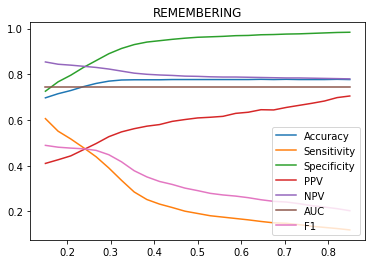

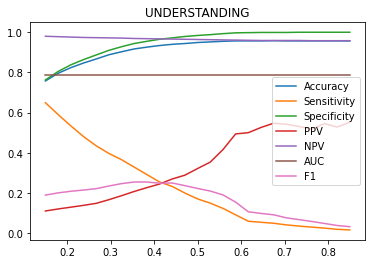

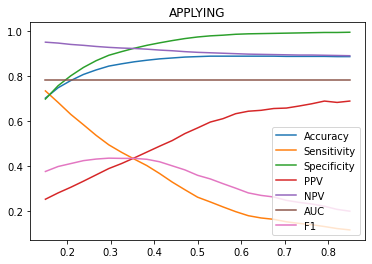

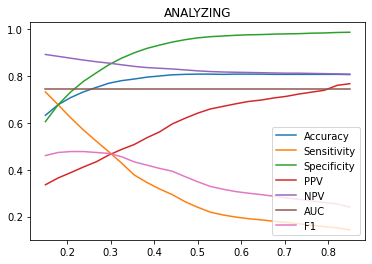

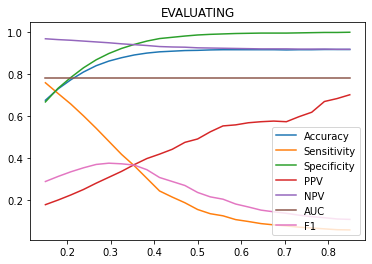

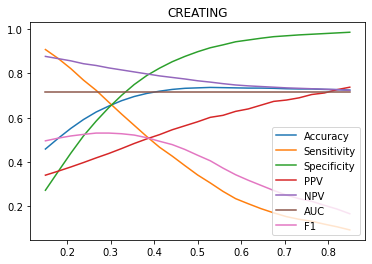

In [81]:
for i in range(len(categories)):
    plt.figure(i+1)
    plt.title(categories[i])
    for metric in list(scores.keys()):
        plt.plot(x, scores[metric][:, i])
    plt.legend(list(scores.keys()))

In [82]:
threshold = [0.25, 0.41, 0.34, 0.3, 0.35, 0.4]
display(metrics.get_performance_metrics(y_valid.values, valid_pred_prob_ensemble, categories, thresholds=threshold))

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,975,15619,625,4134,0.753,0.239,0.464,0.843,0.482,0.833,0.743,0.473,0.25
UNDERSTANDING,160,20081,337,775,0.932,0.044,0.256,0.963,0.242,0.966,0.787,0.249,0.41
APPLYING,687,18213,520,1933,0.858,0.123,0.445,0.915,0.424,0.922,0.781,0.434,0.34
ANALYZING,1096,16169,612,3476,0.771,0.214,0.469,0.853,0.465,0.855,0.747,0.467,0.3
EVALUATING,291,19188,302,1572,0.888,0.087,0.374,0.938,0.364,0.94,0.783,0.369,0.35
CREATING,2140,13559,1540,4114,0.714,0.293,0.486,0.809,0.513,0.792,0.715,0.499,0.4


In [83]:
pipe_chains = [Pipeline([
    ('cv', CountVectorizer(min_df=(i+1), max_df=0.2, stop_words="english")),
    (f'chain_{i}', ClassifierChain(LogisticRegression(random_state=40, class_weight="balanced", solver="liblinear", multi_class="ovr", max_iter=7500)
                             , order='random', random_state=i)),
    ]) for i in range(10)]

In [84]:
print(f"Start {datetime.datetime.now()}")
for i, chain in enumerate(pipe_chains):
    current_time = datetime.datetime.now()
    chain.fit(X_train_transform.values, y_train.values)
    print(f"End Chain {i} after {datetime.datetime.now() - current_time}")

Start 2020-10-26 13:25:04.684769
End Chain 0 after 0:00:15.055505
End Chain 1 after 0:00:13.580627
End Chain 2 after 0:00:07.667260
End Chain 3 after 0:00:07.025107
End Chain 4 after 0:00:07.671851
End Chain 5 after 0:00:07.171923
End Chain 6 after 0:00:06.821836
End Chain 7 after 0:00:06.816328
End Chain 8 after 0:00:07.195357
End Chain 9 after 0:00:06.990150


In [85]:
valid_pred_prob_chains = np.array([
    chain.predict_proba(X_valid_transform) for chain in pipe_chains
])

In [86]:
valid_pred_prob_ensemble = valid_pred_prob_chains.mean(axis=0)
metrics.get_performance_metrics(y_valid.values, valid_pred_prob_ensemble, categories)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,643,15759,485,4466,0.768,0.239,0.126,0.97,0.57,0.779,0.699,0.206,0.5
UNDERSTANDING,134,20135,283,801,0.949,0.044,0.143,0.986,0.321,0.962,0.773,0.198,0.5
APPLYING,638,18272,461,1982,0.886,0.123,0.244,0.975,0.581,0.902,0.77,0.343,0.5
ANALYZING,914,16296,485,3658,0.806,0.214,0.2,0.971,0.653,0.817,0.723,0.306,0.5
EVALUATING,179,19286,204,1684,0.912,0.087,0.096,0.99,0.467,0.92,0.7,0.159,0.5
CREATING,1912,13745,1354,4342,0.733,0.293,0.306,0.91,0.585,0.76,0.7,0.402,0.5


In [87]:
for valid_pred_prob_chain in valid_pred_prob_chains:
    display(metrics.get_performance_metrics(y_valid.values, valid_pred_prob_chain, categories))

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,813,15458,786,4296,0.762,0.239,0.159,0.952,0.508,0.783,0.674,0.242,0.5
UNDERSTANDING,405,17761,2657,530,0.851,0.044,0.433,0.87,0.132,0.971,0.733,0.203,0.5
APPLYING,1406,15658,3075,1214,0.799,0.123,0.537,0.836,0.314,0.928,0.706,0.396,0.5
ANALYZING,1769,14276,2505,2803,0.751,0.214,0.387,0.851,0.414,0.836,0.696,0.4,0.5
EVALUATING,92,19432,58,1771,0.914,0.087,0.049,0.997,0.613,0.916,0.632,0.091,0.5
CREATING,3617,10919,4180,2637,0.681,0.293,0.578,0.723,0.464,0.805,0.703,0.515,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1906,13298,2946,3203,0.712,0.239,0.373,0.819,0.393,0.806,0.647,0.383,0.5
UNDERSTANDING,497,16986,3432,438,0.819,0.044,0.532,0.832,0.126,0.975,0.743,0.204,0.5
APPLYING,1697,14917,3816,923,0.778,0.123,0.648,0.796,0.308,0.942,0.779,0.417,0.5
ANALYZING,1131,15588,1193,3441,0.783,0.214,0.247,0.929,0.487,0.819,0.692,0.328,0.5
EVALUATING,645,16556,2934,1218,0.806,0.087,0.346,0.849,0.18,0.931,0.616,0.237,0.5
CREATING,792,14729,370,5462,0.727,0.293,0.127,0.975,0.682,0.729,0.615,0.214,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,517,15877,367,4592,0.768,0.239,0.101,0.977,0.585,0.776,0.616,0.173,0.5
UNDERSTANDING,441,17279,3139,494,0.83,0.044,0.472,0.846,0.123,0.972,0.689,0.195,0.5
APPLYING,1027,16626,2107,1593,0.827,0.123,0.392,0.888,0.328,0.913,0.709,0.357,0.5
ANALYZING,2010,13704,3077,2562,0.736,0.214,0.44,0.817,0.395,0.842,0.65,0.416,0.5
EVALUATING,1034,14774,4716,829,0.74,0.087,0.555,0.758,0.18,0.947,0.713,0.272,0.5
CREATING,1486,13658,1441,4768,0.709,0.293,0.238,0.905,0.508,0.741,0.647,0.324,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,794,15249,995,4315,0.751,0.239,0.155,0.939,0.444,0.779,0.659,0.23,0.5
UNDERSTANDING,144,19504,914,791,0.92,0.044,0.154,0.955,0.136,0.961,0.715,0.145,0.5
APPLYING,343,18555,178,2277,0.885,0.123,0.131,0.99,0.658,0.891,0.737,0.218,0.5
ANALYZING,2930,11999,4782,1642,0.699,0.214,0.641,0.715,0.38,0.88,0.747,0.477,0.5
EVALUATING,466,17340,2150,1397,0.834,0.087,0.25,0.89,0.178,0.925,0.629,0.208,0.5
CREATING,3456,10888,4211,2798,0.672,0.293,0.553,0.721,0.451,0.796,0.672,0.497,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1167,14659,1585,3942,0.741,0.239,0.228,0.902,0.424,0.788,0.653,0.297,0.5
UNDERSTANDING,52,20249,169,883,0.951,0.044,0.056,0.992,0.235,0.958,0.74,0.09,0.5
APPLYING,356,18546,187,2264,0.885,0.123,0.136,0.99,0.656,0.891,0.725,0.225,0.5
ANALYZING,2168,13221,3560,2404,0.721,0.214,0.474,0.788,0.378,0.846,0.68,0.421,0.5
EVALUATING,1059,14660,4830,804,0.736,0.087,0.568,0.752,0.18,0.948,0.715,0.273,0.5
CREATING,2856,11723,3376,3398,0.683,0.293,0.457,0.776,0.458,0.775,0.631,0.457,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1111,14801,1443,3998,0.745,0.239,0.217,0.911,0.435,0.787,0.659,0.29,0.5
UNDERSTANDING,273,18625,1793,662,0.885,0.044,0.292,0.912,0.132,0.966,0.711,0.182,0.5
APPLYING,1415,15514,3219,1205,0.793,0.123,0.54,0.828,0.305,0.928,0.703,0.39,0.5
ANALYZING,713,16502,279,3859,0.806,0.214,0.156,0.983,0.719,0.81,0.682,0.256,0.5
EVALUATING,546,16873,2617,1317,0.816,0.087,0.293,0.866,0.173,0.928,0.605,0.217,0.5
CREATING,3659,10804,4295,2595,0.677,0.293,0.585,0.716,0.46,0.806,0.707,0.515,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,2419,12394,3850,2690,0.694,0.239,0.473,0.763,0.386,0.822,0.66,0.425,0.5
UNDERSTANDING,47,20228,190,888,0.95,0.044,0.05,0.991,0.198,0.958,0.74,0.08,0.5
APPLYING,364,18530,203,2256,0.885,0.123,0.139,0.989,0.642,0.891,0.733,0.228,0.5
ANALYZING,1090,15764,1017,3482,0.789,0.214,0.238,0.939,0.517,0.819,0.684,0.326,0.5
EVALUATING,1069,14611,4879,794,0.734,0.087,0.574,0.75,0.18,0.948,0.716,0.274,0.5
CREATING,2857,11721,3378,3397,0.683,0.293,0.457,0.776,0.458,0.775,0.633,0.458,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,1744,13769,2475,3365,0.727,0.239,0.341,0.848,0.413,0.804,0.666,0.374,0.5
UNDERSTANDING,44,20318,100,891,0.954,0.044,0.047,0.995,0.306,0.958,0.746,0.082,0.5
APPLYING,651,18058,675,1969,0.876,0.123,0.248,0.964,0.491,0.902,0.737,0.33,0.5
ANALYZING,2976,11886,4895,1596,0.696,0.214,0.651,0.708,0.378,0.882,0.748,0.478,0.5
EVALUATING,92,19436,54,1771,0.915,0.087,0.049,0.997,0.63,0.916,0.687,0.092,0.5
CREATING,3466,10909,4190,2788,0.673,0.293,0.554,0.722,0.453,0.796,0.673,0.498,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,3545,10563,5681,1564,0.661,0.239,0.694,0.65,0.384,0.871,0.73,0.495,0.5
UNDERSTANDING,181,19741,677,754,0.933,0.044,0.194,0.967,0.211,0.963,0.734,0.202,0.5
APPLYING,1431,15449,3284,1189,0.791,0.123,0.546,0.825,0.303,0.929,0.723,0.39,0.5
ANALYZING,705,16521,260,3867,0.807,0.214,0.154,0.985,0.731,0.81,0.68,0.255,0.5
EVALUATING,173,19066,424,1690,0.901,0.087,0.093,0.978,0.29,0.919,0.634,0.141,0.5
CREATING,2325,12420,2679,3929,0.691,0.293,0.372,0.823,0.465,0.76,0.646,0.413,0.5


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,691,15624,620,4418,0.764,0.239,0.135,0.962,0.527,0.78,0.671,0.215,0.5
UNDERSTANDING,517,16669,3749,418,0.805,0.044,0.553,0.816,0.121,0.976,0.731,0.199,0.5
APPLYING,1188,16238,2495,1432,0.816,0.123,0.453,0.867,0.323,0.919,0.689,0.377,0.5
ANALYZING,1654,14457,2324,2918,0.755,0.214,0.362,0.862,0.416,0.832,0.694,0.387,0.5
EVALUATING,84,19439,51,1779,0.914,0.087,0.045,0.997,0.622,0.916,0.628,0.084,0.5
CREATING,3706,10815,4284,2548,0.68,0.293,0.593,0.716,0.464,0.809,0.709,0.52,0.5


In [88]:
pipe = Pipeline([
    ('cv', TfidfVectorizer(max_features=75000)),
    ('ovo', OneVsRestClassifier(LogisticRegression(random_state=40, class_weight="balanced", solver="lbfgs", multi_class="auto", max_iter=7500))),
])

In [89]:
X_train_transform[:5]

71543           differ slope tangent line slope secant line
155386    mani casualti america bomb japan total includ ...
75048     could also find entir area curv f x 1 x 2 neg ...
130361                                           theia come
171257                            nuclear membran disappear
Name: QUERY, dtype: object

In [91]:
pipe.fit(X_train_transform, y_train.values)

Pipeline(steps=[('cv', TfidfVectorizer(max_features=75000)),
                ('ovo',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=7500,
                                                                  random_state=40)))])

In [92]:
valid_pred_prob = pipe.predict_proba(X_valid_transform)
valid_pred_prob[:3]

array([[0.64058525, 0.08370816, 0.13889245, 0.50551024, 0.27349845,
        0.61880585],
       [0.67658268, 0.28303317, 0.10724257, 0.75241551, 0.13335742,
        0.23730357],
       [0.59788925, 0.10227968, 0.70984172, 0.55181295, 0.08763455,
        0.28865313]])

In [93]:
performances = metrics.get_performance_metrics(y_valid.values, valid_pred_prob, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,3564,11560,4684,1545,0.708,0.239,0.698,0.712,0.432,0.882,0.778,0.534,0.5
UNDERSTANDING,573,16724,3694,362,0.81,0.044,0.613,0.819,0.134,0.979,0.806,0.22,0.5
APPLYING,1741,14805,3928,879,0.775,0.123,0.665,0.79,0.307,0.944,0.806,0.42,0.5
ANALYZING,2969,12672,4109,1603,0.732,0.214,0.649,0.755,0.419,0.888,0.779,0.51,0.5
EVALUATING,1241,15716,3774,622,0.794,0.087,0.666,0.806,0.247,0.962,0.818,0.361,0.5
CREATING,3971,10570,4529,2283,0.681,0.293,0.635,0.7,0.467,0.822,0.732,0.538,0.5


In [96]:
classes = np.dot(y_train.values, np.array([0, 1, 2, 3, 4, 5]))

In [97]:
pipe = Pipeline([
    ('cv', TfidfVectorizer(max_features=7500)),
    ('lr', LogisticRegression(random_state=40, class_weight="balanced", solver="lbfgs", multi_class="auto", max_iter=7500)),
])

In [98]:
pipe.fit(X_train_transform, classes)

Pipeline(steps=[('cv', TfidfVectorizer(max_features=7500)),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=7500,
                                    random_state=40))])

In [99]:
valid_pred_prob = pipe.predict_proba(X_valid_transform)
valid_pred_prob[:3]

array([[0.29457963, 0.02377155, 0.05124155, 0.24028043, 0.0848511 ,
        0.30527574],
       [0.3339111 , 0.09650316, 0.03365376, 0.40561466, 0.04168879,
        0.08862852],
       [0.24433305, 0.02171034, 0.38156638, 0.22748114, 0.02767755,
        0.09723153]])

In [100]:
performances = metrics.get_performance_metrics(y_valid.values, valid_pred_prob, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,904,15844,400,4205,0.784,0.239,0.177,0.975,0.693,0.79,0.775,0.282,0.5
UNDERSTANDING,272,19819,599,663,0.941,0.044,0.291,0.971,0.312,0.968,0.812,0.301,0.5
APPLYING,840,18125,608,1780,0.888,0.123,0.321,0.968,0.58,0.911,0.806,0.413,0.5
ANALYZING,1053,16398,383,3519,0.817,0.214,0.23,0.977,0.733,0.823,0.773,0.351,0.5
EVALUATING,596,18854,636,1267,0.911,0.087,0.32,0.967,0.484,0.937,0.821,0.385,0.5
CREATING,736,14874,225,5518,0.731,0.293,0.118,0.985,0.766,0.729,0.731,0.204,0.5


In [104]:
from sklearn.metrics import classification_report

In [107]:
labels = np.array([0, 1, 2, 3, 4, 5])

In [108]:
print(classification_report(np.dot(y_valid.values, labels), np.argmax(valid_pred_prob, axis=1), target_names=performances.index.values))

               precision    recall  f1-score   support

  REMEMBERING       0.51      0.48      0.49      5109
UNDERSTANDING       0.18      0.49      0.26       935
     APPLYING       0.41      0.51      0.45      2620
    ANALYZING       0.52      0.45      0.48      4572
   EVALUATING       0.33      0.52      0.40      1863
     CREATING       0.57      0.36      0.44      6254

     accuracy                           0.44     21353
    macro avg       0.42      0.47      0.42     21353
 weighted avg       0.49      0.44      0.45     21353

